In [51]:
import pandas as pd
import numpy as np

%matplotlib inline

# Modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# for 3D projection
from mpl_toolkits.mplot3d import Axes3D

import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from acquire_mall import get_mall_data
# from summarize import df_summary
# from prepare import data_prep
seed = 123

In [52]:
df_mall = get_mall_data()


In [53]:
df_mall.head()

,customer_id,gender,age,annual_income,spending_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Encode categorical variables to numeric ones

In [54]:
def encode_col(df, col):
    encoder = LabelEncoder()
    encoder.fit(df[col])
    df[col] = encoder.transform(df[col])
    return encoder, df

encoder, df_features = encode_col(df_mall, col='gender')
df_features.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


### Scaled numeric values

In [55]:
scaler = MinMaxScaler()
scaled_array = scaler.fit_transform(df_features)
df_scaled = pd.DataFrame(data=scaled_array, columns=df_features.columns)
df_scaled.head()

,customer_id,gender,age,annual_income,spending_score
0,0.000000,1.0,0.019231,0.000000,0.387755
1,0.005025,1.0,0.057692,0.000000,0.816327
2,0.010050,0.0,0.038462,0.008197,0.051020
3,0.015075,0.0,0.096154,0.008197,0.775510
4,0.020101,0.0,0.250000,0.016393,0.397959


In [56]:
df_scaled['spending_score_bins'] = pd.qcut(df_mall.spending_score, 6, labels=False)

In [57]:
pd.crosstab(df_scaled["gender"], df_scaled["spending_score_bins"], margins=True)


spending_score_bins,0,1,2,3,4,5,All
gender,,,,,,,
0.0,13,22,24,17,18,18,112
1.0,21,11,12,15,14,15,88
All,34,33,36,32,32,33,200


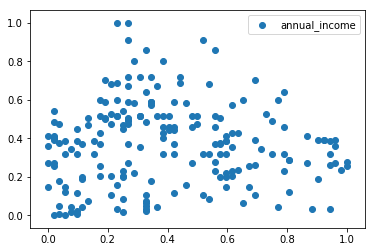

In [58]:
plt.scatter(df_scaled.age, df_scaled.annual_income)
plt.legend()

In [59]:
tbl = pd.crosstab(df_scaled["gender"], df_scaled["spending_score_bins"], margins=True)

stat, p, dof, expected = stats.chi2_contingency(tbl)
prob = .95
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
print(p)


Independent (fail to reject H0)
0.8098126733500757


### Rename the usable dataframe to df

In [60]:
df = df_scaled.drop(columns=['gender'])


### The rote method of finding clusters

In [61]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df)
kmeans.predict(df)

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0], dtype=int32)

In [62]:
kmeans.cluster_centers_

array([[0.54116738, 0.24201183, 0.39697352, 0.80455259, 4.50769231],
       [0.53746344, 0.4598163 , 0.39772449, 0.20804143, 0.49253731],
       [0.42373633, 0.4949095 , 0.32702507, 0.50255102, 2.47058824]])

In [63]:
pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,customer_id,age,annual_income,spending_score,spending_score_bins
cluster,,,,,
0,0.541167,0.242012,0.396974,0.804553,4.507692
1,0.537463,0.459816,0.397724,0.208041,0.492537
2,0.423736,0.494910,0.327025,0.502551,2.470588


In [64]:
df['cluster'] = kmeans.predict(df)
df.head()

,customer_id,age,annual_income,spending_score,spending_score_bins,cluster
0,0.000000,0.019231,0.000000,0.387755,1,1
1,0.005025,0.057692,0.000000,0.816327,5,0
2,0.010050,0.038462,0.008197,0.051020,0,1
3,0.015075,0.096154,0.008197,0.775510,4,0
4,0.020101,0.250000,0.016393,0.397959,1,1


### The elbow method for finding clusters

   k         sse
0  1  769.010653
1  2  258.501445
2  3   89.133490
3  4   71.404193
4  5   54.154268
5  6   37.037526
6  7   30.821459
7  8   25.258097
8  9   20.521635


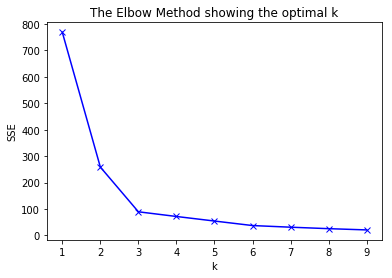

In [66]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [67]:
estimators = [('2 Clusters', KMeans(n_clusters=2)),
              ('4 Clusters', KMeans(n_clusters=4))]

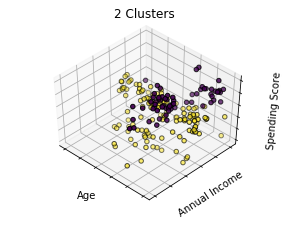

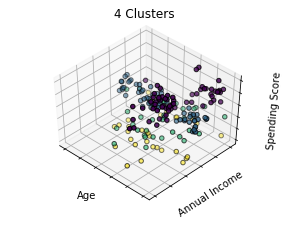

In [68]:
for i, (title, kmeans) in enumerate(estimators):
    # fit the kmeans object
    kmeans.fit(df)

    fig = plt.figure(i + 1, figsize=(4, 3))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = kmeans.labels_

    ax.scatter(df.age, 
               df.annual_income, 
               df.spending_score,
               c=labels.astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('Age')
    ax.set_ylabel('Annual Income')
    ax.set_zlabel('Spending Score')
    ax.set_title(title)
    ax.dist = 12

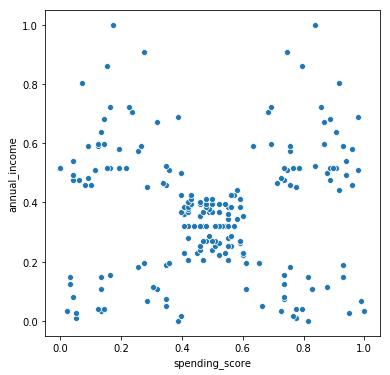

In [69]:
# sns.pairplot(df_scaled[['gender','annual_income','spending_score']], hue='gender')

_, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

sns.scatterplot(df['spending_score'], df['annual_income'])

In [70]:
df_dollar = df.drop(columns=['age'])


   k         sse
0  1  754.649891
1  2  246.573610
2  3   77.247217
3  4   59.584833
4  5   42.335327
5  6   25.240285
6  7   19.211145
7  8   14.514913
8  9    9.103684


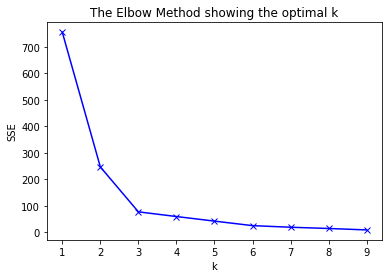

In [71]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_dollar)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [79]:
estimators = [('4 Clusters', KMeans(n_clusters=4)),
              ('5 Clusters', KMeans(n_clusters=5))]

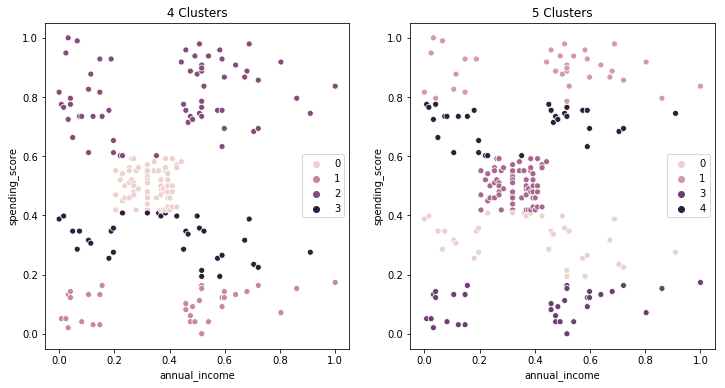

In [80]:
plt.subplots(nrows=1,ncols=2, figsize=(12,6))
for i, (title, kmeans) in enumerate(estimators):
    kmeans.fit(df_dollar)
    labels = kmeans.labels_
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    plt.subplot(1, 2, plot_number)
    plt.title(title)
    sns.scatterplot(df_dollar.annual_income, df_dollar.spending_score, hue=labels)

In [81]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_dollar)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

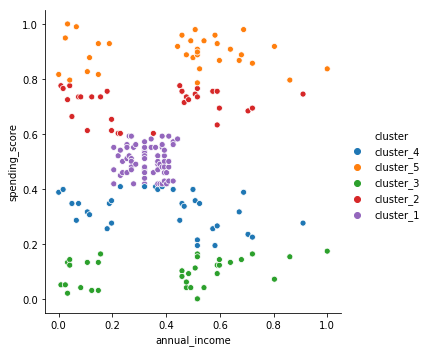

In [83]:
df_scaled['cluster'] = kmeans.predict(df_dollar)
df_scaled.cluster = 'cluster_' + (df_scaled.cluster + 1).astype('str')
sns.relplot(data=df_scaled, x='annual_income', y='spending_score', hue='cluster')

In [27]:
from numpy.random import randint
import itertools as it

In [51]:
data1 = randint(0, 10, 3)
data2 = randint(0,100, 50)
print(data1)
print(data2)

[1 9 6]
[81 21 19 21 67 72 32 11 96  7 88 94 54 70 15 29 84  4 85 25 11 87  4 47
 44 95  3 58  3  3 45 10 94 90 30 36 97 95 49 42 75 47 12 39 46 14 54 50
 50 91]


In [ ]:
for index, (value1, value2) in enumerate(zip(data1, data2)):
    print(index, value1 + value2)

In [ ]:
[x + y for x in data1 for y in data2] + [y + x for x in data1 for y in data2]


In [ ]:
import itertools

In [ ]:
for r in itertools.product(data1, data2): 
    print(r[0] + r[1])

In [52]:
import scipy.stats as stats


In [53]:
stats.ttest_ind(data1, data2)

Ttest_indResult(statistic=-2.2969169184831477, pvalue=0.02576323022504584)